In [1]:
import os 
import numpy as np 
import pandas as pd 
import scanpy as sc
import anndata
import copy
import desc
import matplotlib.pyplot as pl
# following line ensures the pl plots inline 
%matplotlib inline
import plotly.express as px
import plotly.graph_objects as go
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA

In [2]:
from importlib import reload
import GE_functions
reload(GE_functions)

<module 'GE_functions' from '/data/jlu/Chaperone_Analysis/notebooks/GE_functions.py'>

The goal of this noteobok is to make a rank table of genes associated with Rtp1 / Rtp2 expression trajectory across the lineage of cells from GBC_INP_iOSN_mOSN. Additionally, this Olfr is NOT excluded from gene analysis but rather concatenated as a single Olfr gene in a none discriminatory manner. 
Output should be a datatable containing the different processed counts column with ranks of the genes relatively associated to Rtp1 / Rtp2 calculated by mean square error. 

In [3]:
adata = anndata.read_csv('./files/GSE151346_MOE_all_counts.csv')
meta_data = pd.read_table('./files/GSE151346_MOE_metadata.tsv')
meta_data = meta_data.set_index('index')
# transpose used to flip obs and vars.
adata_brann = adata.copy().transpose()

FileNotFoundError: [Errno 2] No such file or directory: 'files/GSE151346_MOE_all_counts.csv'

In [ ]:
# Subset the adata by only cells included in metadata. Attach meta info onto adata
adata_brann = adata_brann[meta_data.index, :]
adata_brann.obs = adata_brann.obs.join(meta_data).dropna(axis = 0)

In [ ]:
# Plotting the provided UMAP coordinates on metafile to visualize 
fig = px.scatter(adata_brann.obs, x='UMAP_1', y= 'UMAP_2', color='leiden_name')
fig.update_traces(marker = dict(size = 3, opacity = 0.5))
fig.update_layout({
    'plot_bgcolor': 'rgba(0, 0, 0, 0)',
    })
fig.show()

In [ ]:
# Subset the adata by interested cells. 
interested_cells = ['mOSN', 'iOSN', 'GBC', 'INP']
interested_cells_id = adata_brann.obs.leiden_name.isin(interested_cells)
adata_brann = adata_brann[interested_cells_id,:]

Now at this point, the anndata object we have only contains of GBC_INP_iOSN_mOSN

In [ ]:
# normalize to depth 10 000
sc.pp.normalize_per_cell(adata_brann, counts_per_cell_after=1e4)
# logaritmize
sc.pp.log1p(adata_brann)

In [ ]:
adata_brann.var['mt'] = adata_brann.var_names.str.startswith('Mt') 
sc.pp.calculate_qc_metrics(adata_brann, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

In [ ]:
# Define genes to be removed from the datasets prior to finding highly variable genes for clustering
mito_genes = adata_brann.var_names.str.startswith('mt-')
malat1 = adata_brann.var_names.str.startswith('Malat')

# Adds the True positions together for a remove list 
remove = np.add(mito_genes, malat1)
keep = np.invert(remove)

adata_brann = adata_brann[:,keep]
print(adata_brann.n_obs, adata_brann.n_vars)

In [ ]:
sc.tl.pca(adata_brann, svd_solver='arpack')
sc.pp.neighbors(adata_brann, n_neighbors=10, n_pcs=40)
sc.tl.draw_graph(adata_brann)
sc.tl.umap(adata_brann)

In [ ]:
sc.set_figure_params(facecolor='white')
sc.pl.umap(adata_brann, color=['Omp', 'Rtp1','leiden_name'])

In [ ]:
# Clustering PAGA via leiden clustering method
sc.tl.leiden(adata_brann, resolution = 0.5)
sc.tl.paga(adata_brann, groups='leiden')

In [ ]:
sc.pl.draw_graph(adata_brann, color=['leiden'], legend_loc='on data')
sc.pl.paga(adata_brann, color=['Omp'])

In [ ]:
sc.tl.draw_graph(adata_brann, init_pos='umap')
sc.pl.draw_graph(adata_brann, color=['leiden', 'leiden_name'], legend_loc='on data')

In [27]:
# Save data with the raw counts
adata = adata_brann.copy()
# adata.write('./files/GSE151346_MOE_ALL_OlfrSeperated.h5ad') 

In [5]:
adata = desc.read_h5ad('../files/Brann/GSE151346_MOE_ALL_Olfr.h5ad')

In [17]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.leiden(adata, resolution = 1)
sc.tl.paga(adata, groups='leiden')

In [18]:
# Store raw counts in adata.raw so we don't lose the values when processing 
adata.raw = adata

In [19]:
sc.pp.normalize_total(adata, target_sum=1e4)
# sc.pp.normalize_total(adata_log1p, target_sum=1e4)
# sc.pp.log1p(adata_log1p)

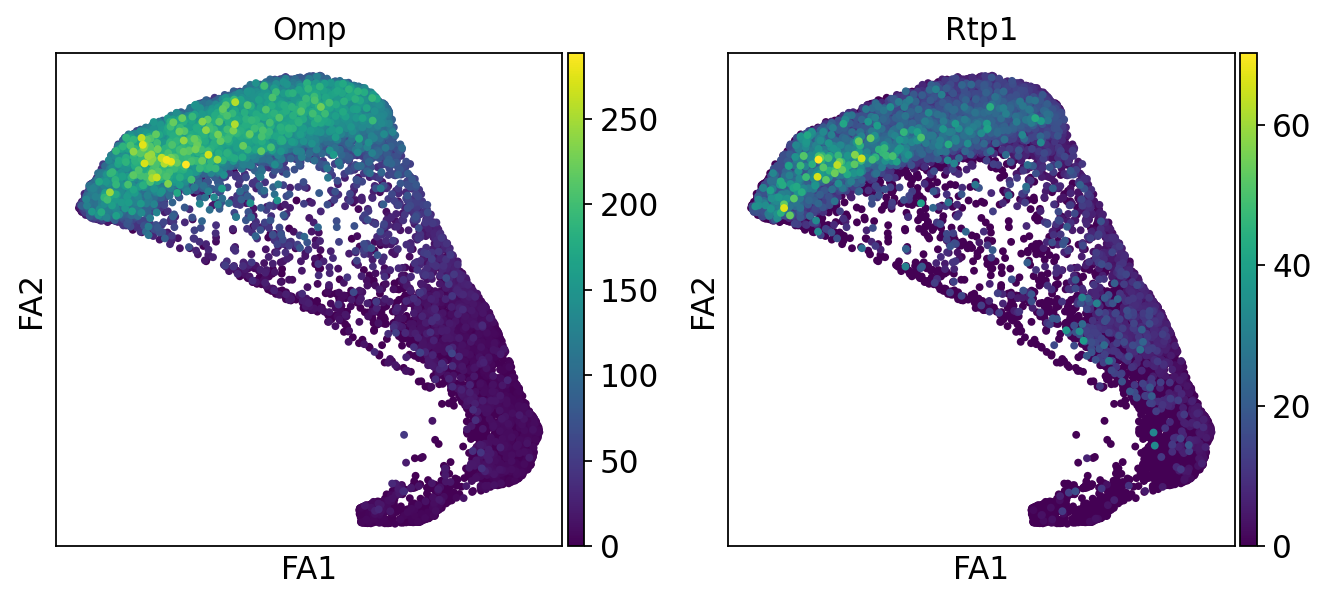

In [22]:
sc.set_figure_params(facecolor='white')
sc.pl.draw_graph(adata, color=['Omp','Rtp1'], legend_loc='right margin', size=50, use_raw=False)

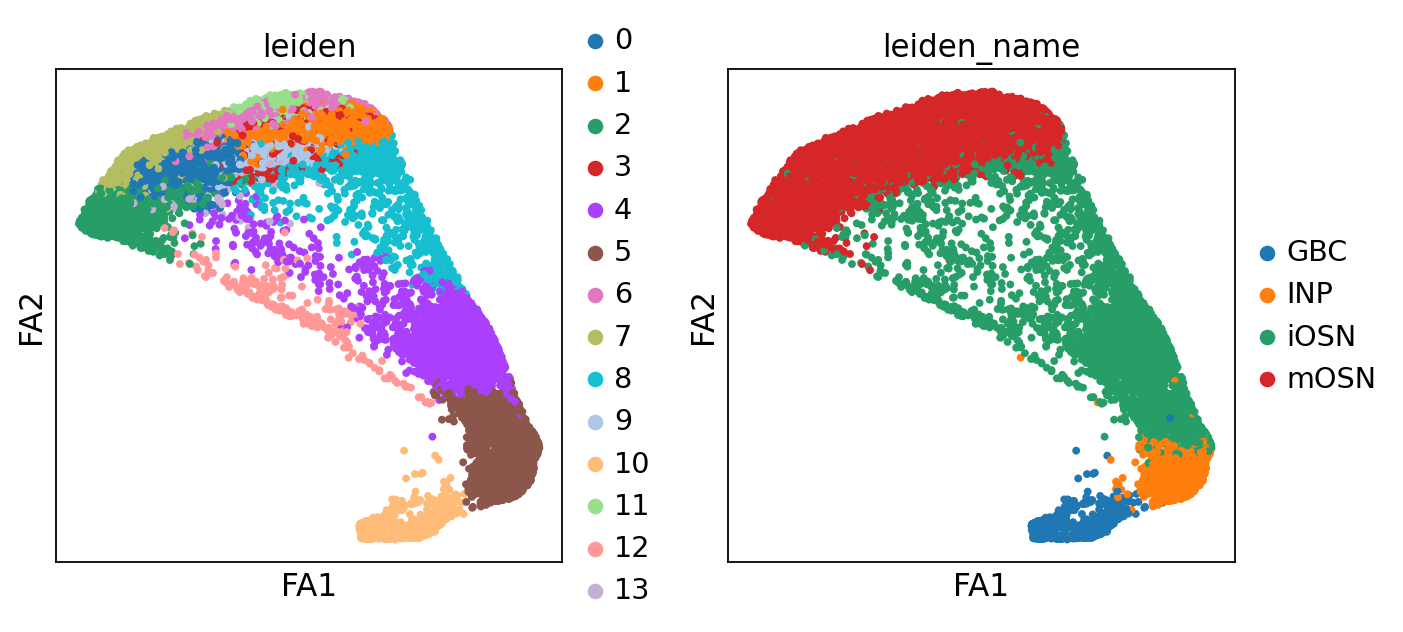

In [34]:
sc.set_figure_params(facecolor='white')
sc.pl.draw_graph(adata, color=['leiden','leiden_name'], 
                 legend_loc='right margin', size=50)

In [25]:
adata.uns['iroot'] = np.flatnonzero(adata.obs['leiden']  == '10')[0]
sc.tl.dpt(adata)
# adata_log1p.uns['iroot'] = np.flatnonzero(adata_log1p.obs['leiden']  == '10')[0]
# sc.tl.dpt(adata_log1p)

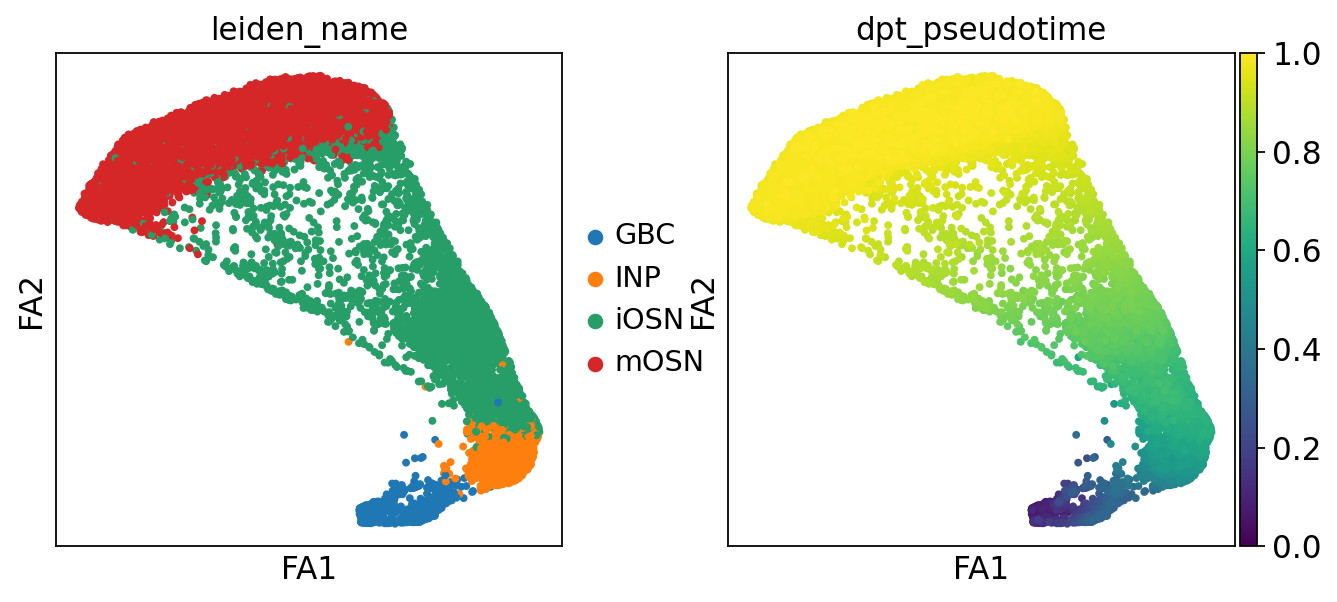

In [26]:
sc.pl.draw_graph(adata, color=['leiden_name', 'dpt_pseudotime'], 
                 legend_loc='right margin', size=50)

/data/jlu/anaconda3/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'selected_dpt' as categorical


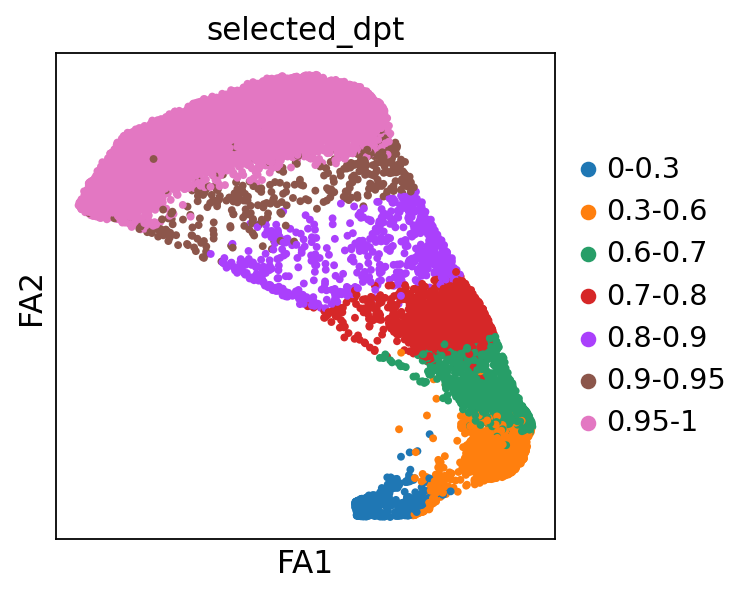

In [32]:
adata = GE_functions.add_selected_dpt(adata, dpt_cutoff=[0,0.3,0.6,0.7,0.8,0.9,0.95,1])
# adata_log1p = GE_functions.add_selected_dpt(adata_log1p, dpt_cutoff=[0,0.3,0.6,0.7,0.8,0.9,0.95,1])
sc.pl.draw_graph(adata, color=['selected_dpt'], 
                 legend_loc='right margin', size=50)

In [4]:
# adata.write('./files/GSE151346_MOE_ALL_OlfrSeperated.h5ad')
adata = sc.read_h5ad('./files/Brann//GSE151346_MOE_ALL_Olfr.h5ad')

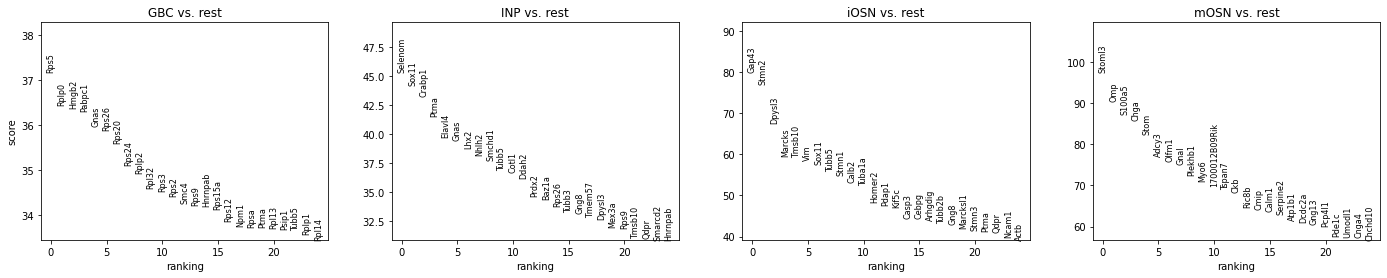

In [22]:
"""
Purpose of this cluster is independent of pseudotime tracing.
The idea here is to simply find the mOSN markers that defines mOSN from the rest of the clusters. 
"""
# # conduct rank gene groups to find markesr for each cluster 
# sc.tl.rank_genes_groups(adata, 'leiden_name', method='wilcoxon')
# sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)
# result = adata.uns['rank_genes_groups']
# groups = result['names'].dtype.names
# # Save rank_gene_result for mOSN to find mOSN markers 
# pd.DataFrame(
#     {'mOSN' + '_' + key: result[key]['mOSN'] for key in ['names', 
#                                                          'pvals',
#                                                          'pvals_adj',
#                                                          'logfoldchanges',
#                                                          'scores']}).sort_values('mOSN_pvals').to_csv('./output/mOSN_rankgenegroup.csv')

In [11]:
gene_names = GE_functions.get_gene_names(adata)
excluded_genes = GE_functions.get_excluded_genes(gene_names)
ORs_list = [ORs for ORs in gene_names if "Olfr" in ORs]
# excluded_genes.append('Olfr_sum')

In [ ]:
adata.var[adata.var.index.str.contains('Olfr')].sort_values('n_cells_by_counts')

In [36]:
# construct ge_table
ge_normalized = GE_functions.get_ge_table(adata, gene_names, ge_across='selected_dpt')
# # convert average gene expression to relative gene expression. (Optional )
ge_normalized = GE_functions.gene_to_relative_expression(ge_normalized)
# Construct mse_table from the ge_table values relative to Rtp1(Default)
mse_normalized_rtp1 = GE_functions.get_mse_table(ge_normalized, gene_names)

# save csv 
# ge_normalized.to_csv('expression_csv/ge_normalized_GSE151346_MOE_ALL_OlfrSeperated.csv')
# mse_normalized_rtp1.to_csv('expression_csv/mse_normalized_rtp1_GSE151346_MOE_ALL_OlfrSeperated_include_Rik_GMgenes.csv')

mse_table constructed


In [3]:
ge_normalized = pd.read_csv('expression_csv/ge_normalized_GSE151346_MOE_ALL_OlfrSeperated.csv', 
                            index_col=0)
mse_normalized_rtp1 = pd.read_csv('expression_csv/mse_normalized_rtp1_GSE151346_MOE_ALL_OlfrSeperated.csv', 
                                 index_col = 0)

In [4]:
from importlib import reload
import GE_functions
reload(GE_functions)

<module 'GE_functions' from '/data/jlu/Chaperone_Analysis/GE_functions.py'>

In [5]:
mOSN_markers = ['Adcy3','Ano2', 'Cnga2', 'Cnga4', 'Cngb1', 'Gnal', 'Gng13', 
                  'Omp','Ric8b','Stom', 'Stoml3']
UPR_markers = ['Atf5', 'Nrp1', 'Sema3a']
cloned_genes = ['Rtbdn','Ebf4','Lingo2','Flrt1','Gpx6','Jph4','Efna3','Hspa12a','Sult1d1','Acsl6','Cfap206','Pde6d','Slc24a2','Ttc21a','Fam217a','Herpud1','Tmbim6','Manea','Clstn2','Ccdc184','Ebf2']
neg_21minus = ['Hspa12a', 'Ccdc184', 'Efna3', 'Clstn2', 'Jph4','Rtbdn']
pos_21minus = ['Cfap206','Lingo2','Acsl6','Sult1d1','Fam217a','Pde6d','Ebf2','Ebf4','Flrt1','Manea','Ttc21a']

In [6]:
"""
Visualize the how cloned genes if the affect of 21minus_gene correlates with RTP1 expression 
BOLD RTP1
"""

fig = go.Figure()

# Plot genes that show negative in 21minus_gene mixture green and positive in red 
ge_data = GE_functions.get_ge_data(ge_normalized, mse_normalized_rtp1[neg_21minus])
for g in ge_data['gene'].unique():
    fig.add_trace(go.Scatter(x= ge_data[ge_data['gene'] == g]['index'], 
                             y= ge_data[ge_data['gene'] == g]['expression'],
                            opacity = 0.3,
                            mode ='lines',
                            name = g,
                            line=dict(
                                color='green',
                                width=5,
                                dash = 'dot'
                            )
                        ))
ge_data = GE_functions.get_ge_data(ge_normalized, mse_normalized_rtp1[pos_21minus])
# Plot genes that show negative in 21minus_gene mixture green and positive in red 
for g in ge_data['gene'].unique():
    fig.add_trace(go.Scatter(x= ge_data[ge_data['gene'] == g]['index'], 
                             y= ge_data[ge_data['gene'] == g]['expression'],
                            opacity = 0.3,
                            mode ='lines',
                            name = g,
                            line=dict(
                                color='red',
                                width=5,
                                dash = 'dot'
                            )
                        ))

# Add bolded lines for specific genes 
ge_data = GE_functions.get_ge_data(ge_normalized, 
                                   mse_normalized_rtp1[['Rtp1']])
for g in ge_data['gene'].unique():
    fig.add_trace(go.Scatter(x= ge_data[ge_data['gene'] == g]['index'], 
                             y= ge_data[ge_data['gene'] == g]['expression'],
                             mode = 'lines',
                             name = g, 
                             line=dict(
                                color='pink',
                                width=5)
    ))
    
ge_data = GE_functions.get_ge_data(ge_normalized, 
                                   mse_normalized_rtp1[UPR_markers])
for g in ge_data['gene'].unique():
    fig.add_trace(go.Scatter(x= ge_data[ge_data['gene'] == g]['index'], 
                             y= ge_data[ge_data['gene'] == g]['expression'],
                             mode = 'lines',
                             opacity = 0.3,
                             name = g, 
                             line=dict(
                                color='purple',
                                width=5)
    ))    
    
fig.update_layout(xaxis_type = 'category',template='simple_white', # update x-axis to category so that it doesn't sort the numbers
                 title="21minus_gene<br> \
                 Green = Negative PE when 21minus_gene<br> \
                 Red = Positive PE when 21minus_gene<br> \
                 Pink = RTP1 <br> \
                 Purple = UPR markers",
                 font=dict(
        size=10,
    ))
fig.show()

# fig.write_html("./output/brann/Chaperone_analysis/ge_line_selected_dpt_ALL_Rtp1_normalized_normExp_21minus_gene.html")

ge_data constructed
ge_data constructed
ge_data constructed
ge_data constructed


In [4]:
mse_df = pd.read_csv('./output/brann/mse_combined_normExp_ALL_Olfr_rtp1.csv', index_col=0)


In [8]:
Syt_list = [i for i in mse_normalized_rtp1.columns if i.startswith('Syt')]
Syt_list.append('Rtp1')

In [25]:
Syt_list = ['Syt1', 'Syt5', 'Chga', 'Chgb', 'Stx1a', 'Stx1b', 'Rtp1', 'Snap25', 'Vamp1', 'Vamp2']

In [26]:
"""
Flexible Plot 
"""

fig = go.Figure()

ge_data = GE_functions.get_ge_data(ge_normalized, 
                                   mse_normalized_rtp1[Syt_list])
for g in ge_data['gene'].unique():
    if g == 'Rtp1':
        fig.add_trace(go.Scatter(x= ge_data[ge_data['gene'] == g]['index'], 
                                 y= ge_data[ge_data['gene'] == g]['expression'],
                                 mode = 'lines',
                                 name = g, 
                                 line=dict(
                                    color='pink',
                                    width=5)
        ))
    else:
        fig.add_trace(go.Scatter(x= ge_data[ge_data['gene'] == g]['index'], 
                                 y= ge_data[ge_data['gene'] == g]['expression'],
                                 mode = 'lines',
                                 name = g, 
                                 line=dict(
#                                     color='pink',
                                    dash='dot',
                                    width=3)
        ))
    
fig.update_layout(xaxis_type = 'category',template='simple_white', # update x-axis to category so that it doesn't sort the numbers
                 title="Syt1 interacting proteins ",
                 font=dict(
        size=10,
    ))
fig.show()

fig.write_html("./output/brann/Chaperone_analysis/ge_line_Syt1_interacting_proteins.html")

ge_data constructed


Visualize OR expression across lineage 

In [ ]:

# ORs_list.append('Rtp1')
or_expression = GE_functions.get_ge_table(adata, ORs_list, ge_across='selected_dpt', sort_by=None)
or_mse_normalized_rtp1 = GE_functions.get_mse_table(or_expression, ORs_list)


In [ ]:
# %matplotlib notebook

ge_data = pd.melt(or_expression, id_vars='index', var_name='gene', value_name='expression')

fig = go.Figure()
# Plot genes that show negative in 21minus_gene mixture green and positive in red 
for g in ge_data['gene'].unique():
    fig.add_trace(go.Scatter(x= ge_data[ge_data['gene'] == g]['index'], 
                             y= ge_data[ge_data['gene'] == g]['expression'],
                            opacity = 0.3,
                            mode ='lines',
                            name = g,
                            line=dict(
                                color='green',
                                width=2,
                                dash = 'dot'
                            )
                        ))
    
fig.update_layout(xaxis_type = 'category',template='simple_white')# update x-axis to category so that it doesn't sort the numbers

fig.show()

# fig.write_html("./output/brann/Chaperone_analysis/ge_line_selected_dpt_ALL_Rtp1_normalized_ORexpression.html")

In [15]:
ge_normalized = pd.read_csv('expression_csv/ge_normalized_GSE151346_MOE_ALL_OlfrSeperated.csv', 
                            index_col=0)
mse_normalized_rtp1 = pd.read_csv('expression_csv/mse_normalized_rtp1_GSE151346_MOE_ALL_OlfrSeperated.csv', 
                                 index_col = 0)

In [16]:
Olfr_DL = pd.read_csv('./expression_csv/Olfr_DL.csv',index_col=0)
# Convert Olfr names to DL names if possible 
converted_columns = copy.deepcopy(ge_normalized.columns)
for i,gene in enumerate(converted_columns):
    if "Olfr" in gene:
        if Olfr_DL['id'].str.contains(gene).sum() > 0: #checks if Olfr is in Olfr_DL 
            converted_columns.values[i] = Olfr_DL[Olfr_DL.id == gene].DL_OR.item()
ge_normalized.columns = converted_columns

converted_columns = copy.deepcopy(mse_normalized_rtp1.columns)
for i,gene in enumerate(converted_columns):
    if "Olfr" in gene:
        if Olfr_DL['id'].str.contains(gene).sum() > 0: 
            converted_columns.values[i] = Olfr_DL[Olfr_DL.id == gene].DL_OR.item()
mse_normalized_rtp1.columns = converted_columns


Subset ORs to class I and class II. 
if ORX, X > 13 --> class I 
else class II 

Attempts to investigate ORs expression  across lineage with respect to RTP1 
If ClassI and ClassII ORs expression patter differs 

In [18]:
OR_list = ge_normalized.columns[ge_normalized.columns.str.contains('OR')]

import re
OR_ClassI = []
OR_ClassII = []
for OR in OR_list: 
#     matches character to letters or alphabet and split
    match = re.match(r"([a-z]+)([0-9]+)", OR, re.I)
    if int(match[2]) > 13 :
        OR_ClassI.append(OR)
    else:
        OR_ClassII.append(OR)


Since there are a lot of receptors that ultimately don't end up expressing. 

Filter for ORs with highest expression at mOSN stage 

OR more than 90% total expression at mOSN stage 

In [19]:

mOR_list = []
for OR in OR_list:
    if ge_normalized[OR][6] > 0.9:
        mOR_list.append(OR)
        
mOR_ClassI = []
mOR_ClassII = []
for OR in mOR_list: 
#     matches character to letters or alphabet and split
    match = re.match(r"([a-z]+)([0-9]+)", OR, re.I)
    if int(match[2]) > 13 :
        mOR_ClassI.append(OR)
    else:
        mOR_ClassII.append(OR)

In [35]:
"""
Visualize the how ORs expression across lineage 
BOLD RTP1
"""

# ORs_list = [ORs for ORs in ge_normalized if "Olfr" in ORs]



fig = go.Figure()

ge_data = GE_functions.get_ge_data(ge_normalized, mse_normalized_rtp1[mOR_ClassII])
for g in ge_data['gene'].unique():
    fig.add_trace(go.Scatter(x= ge_data[ge_data['gene'] == g]['index'], 
                             y= ge_data[ge_data['gene'] == g]['expression'],
                            opacity = 0.3,
                            mode ='lines',
                            name = g,
                            line=dict(
                                color='green',
                                width=2,
                                dash = 'dot'
                            )
                        ))


# Add bolded lines for specific genes 
ge_data = GE_functions.get_ge_data(ge_normalized, 
                                   mse_normalized_rtp1[['Rtp1']])
for g in ge_data['gene'].unique():
    assigned_color = 'black'
    if g == 'Rtp1':
        assigned_color = 'pink'
    fig.add_trace(go.Scatter(x= ge_data[ge_data['gene'] == g]['index'], 
                             y= ge_data[ge_data['gene'] == g]['expression'],
                             mode = 'lines',
                             name = g, 
                             line=dict(
                                color=assigned_color,
                                width=5)
    ))
    
    
fig.update_layout(xaxis_type = 'category',template='simple_white', # update x-axis to category so that it doesn't sort the numbers
                 title="Normalized Class II OR expression<br>filtered by final dpt_time OR expression > .9 of total expression",
                 font=dict(
        size=10,
    ))

fig.show()

fig.write_html("./output/brann/Chaperone_analysis/ge_line_selected_dpt_ALL_Rtp1_normalized_normExp_ORclassII.html")

ge_data constructed
ge_data constructed


In [38]:
# Makes a plot for the top 1000 genes associated with RTP1 in a line graph 
top_X_gene = mse_normalized_rtp1.transpose().sort_values('mse',ascending=True).iloc[:100].index
# top1000_msetable = list(set(list(top1000_msetable.columns)+excluded_genes))
fig = GE_functions.expression_line_plot(ge_normalized, 
                                        mse_normalized_rtp1[top_X_gene])
fig = fig.update_layout(title = 'Relative gene expression change across normalized counts selected_dpt relative Rtp1 \n Data from Brann GBC/INP/iOSN/mOSN')
fig.update_layout(xaxis_type = 'category',template='simple_white')
fig.show()

# fig.write_html("./output/brann/ge_line_selected_dpt_ALL_Olfr_Rtp1_normalized_normExp_top100.html")


ge_data constructed


In [54]:
excluded_genes = excluded_genes + ['Clgn', 'Gfy']
fig = GE_functions.expression_line_plot(ge_normalized, 
                                        GE_functions.filter_mse_table(mse_normalized_rtp1, excluded_genes))
fig = fig.update_layout(title = 'Relative gene expression change across normalized counts selected_dpt relative Rtp1 \n Data from Brann GBC/INP/iOSN/mOSN')
# fig.write_html("./output/brann/ge_line_selected_dpt_ALL_Olfr_Rtp1_normalized_normExp.html")
fig.show()

18559 genes dropped from mse_table
mse_table constructed


In [ ]:
# plotting logmarthize 
fig = GE_functions.expression_line_plot(ge_log1p, 
                                        GE_functions.filter_mse_table(mse_log1p_rtp1, excluded_genes))
fig = fig.update_layout(title = 'Relative gene expression change across log1p counts selected_dpt relative Rtp1 \n Data from Brann GBC/INP/iOSN/mOSN')
# fig.write_html("./output/brann/ge_line_selected_dpt_ALL_Olfr_Rtp1_log1p_normExp.html")
fig.show()

In [38]:
# # saving ge_table files
# ge_log1p.to_csv('./output/brann/ge_table_ALL_Olfr_Rtp1_log1p_normExp.csv')
# ge_normalized.to_csv('./output/brann/ge_table_ALL_Olfr_Rtp1_normalized_normExp.csv')

In [180]:
# # combining normalized and processed mse_table and save 
# mse_combined = mse_normalized_rtp1.transpose().rename(columns = {'mse': 'mse_normalized_ALL_Olfr_rtp1'}).join(
#     mse_log1p_rtp1.transpose().rename(columns = {'mse': 'mse_log1p_ALL_Olfr_rtp1'}))
# mse_combined.to_csv('./output/brann/mse_combined_ALL_Olfr_rtp1.csv')

In [151]:
# combining normalized and processed mse_table and save 
mse_combined = mse_normalized_rtp1.transpose().rename(columns = {'mse': 'mse_normalized_normExp_ALL_Olfr_rtp1'}).join(
    mse_log1p_rtp1.transpose().rename(columns = {'mse': 'mse_log1p_normExp_ALL_Olfr_rtp1'}))
mse_combined.to_csv('./output/brann/mse_combined_normExp_ALL_Olfr_rtp1.csv')

In [ ]:
# calculate mse_table relative to rtp2
mse_normalized_rtp2 = GE_functions.get_mse_table(ge_normalized, gene_names, mse_gene='Rtp2')
mse_log1p_rtp2 = GE_functions.get_mse_table(ge_log1p, gene_names, mse_gene='Rtp2')
# combining normalized and processed mse_table and save 
mse_combined = mse_normalized_rtp2.transpose().rename(columns = {'mse': 'mse_normalized_normExp_ALL_Olfr_rtp2'}).join(
    mse_log1p_rtp2.transpose().rename(columns = {'mse': 'mse_log1p_normExp_ALL_Olfr_rtp2'}))
# mse_combined.to_csv('./output/brann/mse_combined_ALL_Olfr_rtp2.csv')
mse_combined.to_csv('./output/brann/mse_combined_normExp_ALL_Olfr_rtp2.csv')

In [ ]:
# plotting normalized
fig = GE_functions.expression_line_plot(ge_normalized, 
                                        GE_functions.filter_mse_table(mse_normalized_rtp2, excluded_genes))
fig = fig.update_layout(title = 'Relative gene expression change across normalized selected_dpt relative Rtp2 \n Data from Brann GBC/INP/iOSN/mOSN')
fig.write_html("./output/brann/ge_line_selected_dpt_ALL_Olfr_Rtp2_normalized_normExp.html")
fig.show()

In [ ]:
# plotting normalized
fig = GE_functions.expression_line_plot(ge_log1p, 
                                        GE_functions.filter_mse_table(mse_log1p_rtp2, excluded_genes))
fig = fig.update_layout(title = 'Average gene expression change across log1p selected_dpt relative Rtp2 \n Data from Brann GBC/INP/iOSN/mOSN')
fig.write_html("./output/brann/ge_line_selected_dpt_ALL_Olfr_Rtp2_processed_normExp.html")
fig.show()

In [ ]:
# End of saving plots and mse files 

In [64]:
mse_combined = pd.read_csv('./output/brann/mse_combined_normExp_ALL_Olfr_rtp1.csv', index_col=[0])

In [5]:
gene_names = list(mse_combined.index)
excluded_genes = GE_functions.get_excluded_genes(gene_names)
excluded_genes.append('Olfr_sum')

In [6]:
reload(GE_functions)

<module 'GE_functions' from '/data/jlu/scSeq_tsukahara/GE_functions.py'>

In [72]:
fig = GE_functions.rank_plot(mse_combined, 
            title = "normalized vs log1p relExp counts relative to Rtp1 (GBC/INP/iOSN/mOSN)",
                              excluded_genes=['Rtp1', 'Gfy', 'Clgn'])
fig.show()
# fig.write_html("./output/brann/Scatter_combined_normExp_ALL_Olfr_rtp1.html")


Translate the mse_combined mse into numerical ranks. So that when plotted, it's a direct numerical comparison instead of the skewed mse values 


In [66]:
# For the columns in mse_combined (before ranks are added), sort them by the value of the column and add ranks 
for col in mse_combined.columns.unique():
    mse_combined.sort_values(by=col, inplace=True)
    mse_combined[str(col+'_Rank')] = list(range(1,len(mse_combined)+1))

mse_combined.to_csv('./output/brann/rank_mse_combined_normExp_ALL_Olfr_rtp1.csv')

In [243]:
mse_combined_rtp1 = pd.read_csv('./output/brann/mse_combined_normExp_ALL_Olfr_rtp1.csv', index_col=[0])
rank_combined_rtp1 = GE_functions.mse_to_rank(mse_combined_rtp1, col_names=['mse_rank_normalized_normExp_ALL_Olfr_rtp1',
                                                 'mse_rank_log1p_normExp_ALL_Olfr_rtp1'])
mse_combined_rtp2 = pd.read_csv('./output/brann/mse_combined_normExp_ALL_Olfr_rtp2.csv', index_col=[0])
rank_combined_rtp2 = GE_functions.mse_to_rank(mse_combined_rtp2, col_names=['mse_rank_normalized_normExp_ALL_Olfr_rtp2',
                                                 'mse_rank_log1p_normExp_ALL_Olfr_rtp2'])
# For reindexing if ever need to match index to master list 
index_order = pd.read_csv('./output/brann/Rank_gene_combined_ALL_Olfr_rtp1.csv', index_col=[0]).index
rank_combined_rtp1.reindex(index_order).to_csv('./output/brann/Rank_gene_combined_normExp_ALL_Olfr_rtp1.csv')
rank_combined_rtp2.reindex(index_order).to_csv('./output/brann/Rank_gene_combined_normExp_ALL_Olfr_rtp2.csv')

In [70]:
# subset the last two rows of ranks 
rank_combined_rtp1 = mse_combined.iloc[:,2:4]

fig = GE_functions.rank_plot(rank_combined_rtp1, 
                             title = "normalized vs log1p rank relative to Rtp1 (GBC/INP/iOSN/mOSN)",
                             excluded_genes=['Rtp1', 'Gfy', 'Clgn'])
fig.show()
# fig.write_html("./output/brann/Scatter_rank_combined_normExp_ALL_Olfr_rtp1.html")

In [ ]:
fig = GE_functions.rank_plot(rank_combined_rtp2, 
                             title = "normalized vs log1p rank relative to Rtp2 (GBC/INP/iOSN/mOSN)",
                             excluded_genes=excluded_genes)
fig.show()
# fig.write_html("./output/brann/Scatter_rank_combined_normExp_ALL_Olfr_rtp2.html")

In [223]:
combined = pd.read_csv('./output/brann/mse_combined_ALL_Olfr_rtp1.csv', index_col=[0])
combined_normExp = pd.read_csv('./output/brann/mse_combined_normExp_ALL_Olfr_rtp1.csv', index_col=[0])

In [224]:
rank_normalized = pd.DataFrame(index = combined[combined.columns[0]].sort_values().index)
rank_normalized['mse_rank_normalized_rtp1'] = rank_index
rank_norm_normExp = pd.DataFrame(index = combined_normExp[combined_normExp.columns[0]].sort_values().index)
rank_norm_normExp['mse_rank_normalized_normExp_rtp1'] = rank_index
rank_combined = rank_normalized.join(rank_norm_normExp)
# rank_combined.to_csv('./output/brann/Rank_gene_combined_normExp_ALL_rtp2.csv')


In [247]:
index_order = pd.read_csv('./output/brann/Rank_gene_combined_ALL_Olfr_rtp1.csv', index_col=[0]).index


In [248]:
temp = pd.read_csv('./output/brann/NEURON_genes_rank.csv', index_col=[0])
temp.reindex(index_order).to_csv('./output/brann/NEURON_genes_rank.csv')
temp = pd.read_csv('./output/brann/NEURON_genes_rank_reversed.csv', index_col=[0])
temp.reindex(index_order).to_csv('./output/brann/NEURON_genes_rank_reversed.csv')
temp = pd.read_csv('./output/brann/CELL_genes_rank.csv', index_col=[0])
temp.reindex(index_order).to_csv('./output/brann/CELL_genes_rank.csv')
temp = pd.read_csv('./output/brann/CELL_genes_rank_reversed.csv', index_col=[0])
temp.reindex(index_order).to_csv('./output/brann/CELL_genes_rank_reversed.csv')

In [37]:
pd.read_csv('./output/brann/CELL_genes_rank.csv', index_col=[0])

Atypical OSN  Bowman's gland    GBC    INP  Immune  MV Brush-like  \
Rtp1               114           17299  17309  17288   17252          17287   
Syt1               546           17307  17296  17305   17276          17289   
Rtp2              2662           17295  17302  17296   17255          17280   
Arhgef28         17290           17255  17270  17284   17223          16958   
Gramd1c           4821           17276  17295  17304   17248          17231   
...                ...             ...    ...    ...     ...            ...   
Tmsb4x           17328             718    538    171     105          17364   
S100a5           17367           17354  17360  17363   17347          17356   
Olfr_sum         17371           17369  17370  17367   17365          17367   
Malat1             278             874  17310  17279   16759          17044   
Calm1            16808           17359  17368  17371   17367          17370   

          MV Ionocyte-like  Olf. HBC  Resp. HBC  Resp. ciliated  \
Rtp1                 17293     17291      17271           17309   
Syt1                 17298     17295      17304           17313   
Rtp2                 17277     17279      17283           17296   
Arhgef28             17165     17258      17264           16902   
Gramd1c              17273     17271      17269           17250   
...                    ...       ...        ...             ...   
Tmsb4x               17289      1297      16026           17276   
S100a5               17356     17350      17349           17353   
Olfr_sum             17368     17369      17369           17370   
Malat1                 226      8573       3909             796   
Calm1                17371     17371      17371           17290   

          Resp. secretory  SUS Dorsal  SUS Ventral  Smooth muscle   iOSN  \
Rtp1                17293       17311        17306          17284  16377   
Syt1                17304       17304        17304          17279  17172   
Rtp2                17297       17292        17294          17250  16416   
Arhgef28            17223       17047        17208          17174   5498   
Gramd1c             17277       17275        17271          17231  17167   
...                   ...         ...          ...            ...    ...   
Tmsb4x              16811         751          545          17302  16518   
S100a5              17346       17356        17352          17353  17369   
Olfr_sum            17369       17370        17368          17366   3371   
Malat1              14125       16791        16880            326  16331   
Calm1               17371       17362        17370          17371  16919   

           mOSN  
Rtp1         58  
Syt1         50  
Rtp2         62  
Arhgef28    110  
Gramd1c      57  
...         ...  
Tmsb4x    16575  
S100a5        3  
Olfr_sum     12  
Malat1      323  
Calm1         6  

[17372 rows x 16 columns]